In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random

plt.rcParams['font.size']=10
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

# Load profile generation

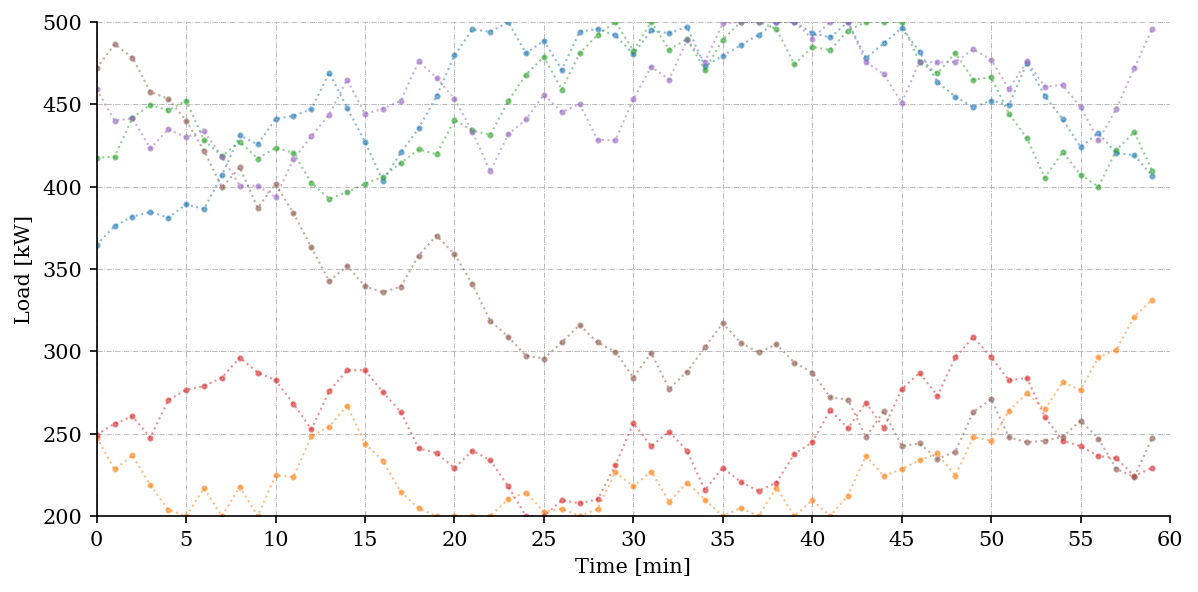

In [2]:
PROFILES = 200
MIN_LOAD = 200
MAX_LOAD = 500
MAX_CONSECUTIVE_DIFF = 25
MINUTES = 60
OMEGA = 50 # sample size

# Generate 200 load profiles for 60 minutes with 1-minute resolution (floats)
# Maximum spacing of -25 kW or 25 kW between two consecutive values

np.random.seed(0) # set seed for reproducibility

load_profiles = []

plt.figure(figsize=(8, 4), dpi=150)

for i in range(PROFILES):
    load_profile = []
    for j in range(MINUTES):
        if j == 0:
            load = np.random.uniform(MIN_LOAD, MAX_LOAD) #first value is sampled from uniform distribution between MIN_LOAD and MAX_LOAD
        else:
            # next value is sampled from uniform distribution between -MAX_CONSECUTIVE_DIFF and MAX_CONSECUTIVE_DIFF 
            # to ensure that the absolute difference between two consecutive values is at most MAX_CONSECUTIVE_DIFF
            load = load_profile[j-1] + np.random.uniform(-MAX_CONSECUTIVE_DIFF, MAX_CONSECUTIVE_DIFF + 1)

            #Ensure that the value is within the bounds after adding the consecutive difference
            if load < MIN_LOAD:
                load = MIN_LOAD
            if load > MAX_LOAD:
                load = MAX_LOAD

        load_profile.append(load) #append the load value for minute j

    load_profiles.append(load_profile) # append the load profile to the list of load profiles

    # Visualize a few load profiles
    if i < 6:
        plt.plot(load_profile, alpha=0.5, linewidth=1, linestyle=':', marker='o', markersize=2)
    
plt.margins(x=0)
plt.xlabel('Time [min]')
plt.ylabel('Load [kW]')
plt.tight_layout()
plt.ylim([MIN_LOAD, MAX_LOAD])
plt.xticks(np.arange(0, 65, 5))

plt.show()

Save the load profiles to JSON

In [3]:
consumption_profiles = {}

for i, profile in enumerate(load_profiles):
    consumption_profiles[i] = profile

# with open('Data/ALL_scenarios_consumption.json', 'w') as f:
#     json.dump(consumption_profiles, f)

# Step 2 tasks

Read the saved file and get in-sample scenarios

In [18]:
with open('Data/ALL_scenarios_consumption.json', 'r') as f:
    all_scenarios = json.load(f)

random.seed(0)

# Sample scenarios without replacement
in_sample_scenarios = random.sample(range(PROFILES), OMEGA)

print(in_sample_scenarios)
print('Number of samples:' , len(in_sample_scenarios))

scenarios = {}

# Extract sampled scenarios from dictionary containing all scenarios
for i in range(OMEGA):
    scenarios[i] = all_scenarios[str(in_sample_scenarios[i])]

[98, 194, 107, 10, 66, 130, 124, 103, 77, 122, 91, 149, 55, 129, 35, 72, 185, 24, 158, 64, 136, 154, 37, 79, 25, 18, 84, 120, 143, 175, 90, 111, 80, 156, 163, 52, 141, 190, 113, 133, 195, 15, 140, 3, 23, 102, 0, 126, 85, 62]
Number of samples: 50


## In-sample decision making: Offering strategy under P90 rule

### Method: ALSO-X

In [ ]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

m.setParam('OutputFlag', 0)

#============= Variables =============
p_bid_UP = m.addVar(lb=0, ub=gb.GRB.INFINITY, name="p_bid_UP")  # day-ahead upwards reserve bid
y = m.addVars(MINUTES, OMEGA, type=gb.GRB.BINARY, name="y")  # binary variable ALSO-X

#============= Objective function =============
# Define objective function

obj = p_bid_UP

m.setObjective(obj, direction)

#============= Constraints =============
M = 1e4 # Big M

m.addConstrs(p_bid_UP - scenarios[w][t] <=  y[t,w] * M for t in range(MINUTES) for w in range(OMEGA))
m.addConstr(gb.quicksum(y[t,w] for t in range(MINUTES) for w in range(OMEGA)) <= 0.10 * MINUTES * OMEGA)

m.addConstr(p_bid_UP >= 0)

#============= Display and run model =============
m.update()
m.optimize()

#============= Results =============

if m.status == gb.GRB.OPTIMAL:
    print('Optimal objective value: %g' % m.objVal)
    print('Optimal solution:')
    for v in m.getVars():
        print('%s = %g' % (v.varName, v.x))

### Method: CVaR

In [ ]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

m.setParam('OutputFlag', 0)

#============= Variables =============
p_bid_UP = m.addVar(lb=0, ub=gb.GRB.INFINITY, name="p_bid_UP")  # day-ahead upwards reserve bid
beta = m.addVar(lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="beta")
zeta = m.addVars(MINUTES, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="zeta") 

#============= Objective function =============
# Define objective function

obj = p_bid_UP

m.setObjective(obj, direction)

#============= Constraints =============
m.addConstrs(p_bid_UP - scenarios[w][t] <=  zeta[t,w] for t in range(MINUTES) for w in range(OMEGA))
m.addConstr(1/(MINUTES * OMEGA) * gb.quicksum(zeta[t,w] for t in range(MINUTES) for w in range(OMEGA)) <= (1 - 0.10) * beta)

#Limits
m.addConstr(p_bid_UP >= 0)
m.addConstr(beta <= 0)
m.addConstr(beta <= zeta[t,w] for t in range(MINUTES) for w in range(OMEGA))

#============= Display and run model =============
m.update()
m.optimize()

#============= Results =============

if m.status == gb.GRB.OPTIMAL:
    print('Optimal objective value: %g' % m.objVal)
    print('Optimal solution:')
    for v in m.getVars():
        print('%s = %g' % (v.varName, v.x))

## Out-of-sample analysis

## Energinet perspective